# Conditioning climate drivers on extreme values of FFDI and DI

### Time taken: < 1 min

#### This notebook includes the creation of Figs 6 and 7

------

In [1]:
import numpy as np
import xarray as xr
import scipy

import myfuncs as my

import cartopy
import cartopy.crs as ccrs
import matplotlib
from matplotlib import cm
import matplotlib.pyplot as plt
import cmasher as cmr

from dask.distributed import Client
from dask_jobqueue import PBSCluster

import warnings
warnings.filterwarnings("ignore")

In [2]:
cartopy.config['pre_existing_data_dir'] = '/g/data/xv83/ds0092/data/cartopy-data'
cartopy.config['data_dir'] = '/g/data/xv83/ds0092/data/cartopy-data'

In [3]:
walltime = '02:00:00'
cores = 48
memory = '192GB'
cluster = PBSCluster(walltime=str(walltime), cores=cores, memory=str(memory),
                     job_extra=['-l ncpus='+str(cores),
                                '-l mem='+str(memory),
                                '-P xv83',
                                '-l jobfs=100GB',
                                '-l storage=gdata/xv83+gdata/v14+scratch/v14'],
                     local_directory='$PBS_JOBFS',
                     # env_extra=['export MALLOC_TRIM_THRESHOLD_="0"'],
                     header_skip=["select"])

In [4]:
cluster.scale(jobs=1)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.6.47.31:8787/status,
Dashboard: http://10.6.47.31:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.6.47.31:34169,Workers: 0
Dashboard: http://10.6.47.31:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


--------
# Parameters

In [5]:
fcst_period = slice('2014-01-01', '2023-12-31')
obsv_period = slice('2014-01-01', '2020-12-31')

MIN_LEAD = 37 # For independece

--------
# Load and align model and historical data

In [6]:
def lead_days_to_months(fcst, days_to_zero_lead=60):
    """ Hack to convert lead_time in days to months """
    forecast_month = np.unique(fcst.time.dt.month)
    assert len(forecast_month) == 1
    forecast_month = forecast_month[0]

    lead_year = np.floor(((fcst.lead_time - days_to_zero_lead) / 365))
    lead_month = lead_year * 12 + forecast_month - fcst.init_date.dt.month
    return fcst.assign_coords({'lead_time': lead_month})

### Historical data

In [7]:
jra_FFDI = my.open_zarr(
    'data/JRA-55_FFDI-DEC-mean_region.zarr',
    open_zarr_kwargs={'use_cftime':True})['FFDI_DEC'].compute()

In [8]:
awap_DI = my.open_zarr(
    'data/AWAP_precip-annDEC-accl_region.zarr',
    open_zarr_kwargs={'use_cftime':True})['precip_ann'].compute()

In [9]:
had_nino34 = my.open_zarr(
    'data/HadISST_Nino34-SOND.zarr',
    open_zarr_kwargs={'use_cftime':True})['nino34_SOND']

had_nino34 = my.round_to_end_of_month(had_nino34).compute()

In [10]:
had_dmi = my.open_zarr(
    'data/HadISST_DMI-SON.zarr',
    open_zarr_kwargs={'use_cftime':True})['dmi_SON']

# Reference to December
had_dmi = my.round_to_end_of_month(had_dmi)
had_dmi = had_dmi.assign_coords({'time': had_dmi.get_index('time').shift(1, 'M')}).compute()

In [11]:
jra_sam = my.open_zarr(
    'data/JRA-55_SAM-SOND.zarr',
    open_zarr_kwargs={'use_cftime':True})['sam_SOND']

jra_sam = my.round_to_end_of_month(jra_sam).compute()

### Model data

In [12]:
f6_FFDI = my.open_zarr(
    'data/CAFE-f6_FFDI-DEC-mean_region.zarr.zip')['FFDI_DEC']
f6_FFDI = lead_days_to_months(f6_FFDI)
f6_FFDI = f6_FFDI.where(f6_FFDI.lead_time >= MIN_LEAD, drop=True)
f6_FFDI = f6_FFDI.assign_coords({
    'lead_time': f6_FFDI.lead_time.where(f6_FFDI.lead_time >= MIN_LEAD)}).compute()

In [13]:
f6_DI = my.open_zarr(
    'data/CAFE-f6_precip-annDEC-accl_region_bc.zarr.zip')['precip_ann']
f6_DI = f6_DI.where(f6_DI.lead_time >= MIN_LEAD, drop=True)
f6_DI = f6_DI.assign_coords({
    'lead_time': f6_DI.lead_time.where(f6_DI.lead_time >= MIN_LEAD)}).compute()

In [14]:
f6_sst = my.open_zarr(
    'data/CAFE-f6_sst-SON.zarr')['sst_SON']

# Derived from monthly forecast data so round times to end of month
f6_sst = my.round_to_end_of_month(f6_sst)

# SON average so shift times and leads by 1 month to align with other indices
f6_sst = f6_sst.assign_coords({'lead_time': f6_sst.lead_time+1})
f6_sst = f6_sst.assign_coords({'time': f6_sst.get_index('time').shift(1, 'M')})

f6_sst = f6_sst.where(f6_sst.lead_time >= MIN_LEAD, drop=True)
f6_sst = f6_sst.assign_coords({
    'lead_time': f6_sst.lead_time.where(f6_sst.lead_time >= MIN_LEAD)})

# # Derived from monthly forecast data so replace init_dates
f6_sst = f6_sst.assign_coords({'init_date': f6_FFDI.init_date})

In [15]:
f6_h500 = my.open_zarr(
    'data/CAFE-f6_h500-SOND.zarr')['h500_SOND']

# Derived from monthly forecast data so round times to end of month
f6_h500 = my.round_to_end_of_month(f6_h500)

f6_h500 = f6_h500.where(f6_h500.lead_time >= MIN_LEAD, drop=True)
f6_h500 = f6_h500.assign_coords({
    'lead_time': f6_h500.lead_time.where(f6_h500.lead_time >= MIN_LEAD)})

# Derived from monthly forecast data so replace init_dates
f6_h500 = f6_h500.assign_coords({'init_date': f6_FFDI.init_date}).compute()

In [16]:
f6_nino34 = my.open_zarr(
    'data/CAFE-f6_Nino34-SOND.zarr')['nino34_SOND']

# Derived from monthly forecast data so round times to end of month
f6_nino34 = my.round_to_end_of_month(f6_nino34)

f6_nino34 = f6_nino34.where(f6_nino34.lead_time >= MIN_LEAD, drop=True)
f6_nino34 = f6_nino34.assign_coords({
    'lead_time': f6_nino34.lead_time.where(f6_nino34.lead_time >= MIN_LEAD)})

# Derived from monthly forecast data so replace init_dates
f6_nino34 = f6_nino34.assign_coords({'init_date': f6_FFDI.init_date})

f6_nino34 = f6_nino34.where(f6_FFDI.notnull().drop('lead_time')).compute()

In [17]:
f6_dmi = my.open_zarr(
    'data/CAFE-f6_DMI-SON.zarr')['dmi_SON']

# Derived from monthly forecast data so round times to end of month
f6_dmi = my.round_to_end_of_month(f6_dmi)

# SON average so shift times and leads by 1 month to align with other indices
f6_dmi = f6_dmi.assign_coords({'lead_time': f6_dmi.lead_time+1})
f6_dmi = f6_dmi.assign_coords({'time': f6_dmi.get_index('time').shift(1, 'M')})

f6_dmi = f6_dmi.where(f6_dmi.lead_time >= MIN_LEAD, drop=True)
f6_dmi = f6_dmi.assign_coords({
    'lead_time': f6_dmi.lead_time.where(f6_dmi.lead_time >= MIN_LEAD)})

# # Derived from monthly forecast data so replace init_dates
f6_dmi = f6_dmi.assign_coords({'init_date': f6_FFDI.init_date})

f6_dmi = f6_dmi.where(f6_FFDI.notnull().drop('lead_time')).compute()

In [18]:
f6_sam = my.open_zarr(
    'data/CAFE-f6_SAM-SOND.zarr')['sam_SOND']

# Derived from monthly forecast data so round times to end of month
f6_sam = my.round_to_end_of_month(f6_sam)

f6_sam = f6_sam.where(f6_sam.lead_time >= MIN_LEAD, drop=True)
f6_sam = f6_sam.assign_coords({
    'lead_time': f6_sam.lead_time.where(f6_sam.lead_time >= MIN_LEAD)})

# Derived from monthly forecast data so replace init_dates
f6_sam = f6_sam.assign_coords({'init_date': f6_FFDI.init_date})

f6_sam = f6_sam.where(f6_FFDI.notnull().drop('lead_time')).compute()

--------
# Create composites where FFDI and DI are extreme

In [19]:
FFDI_event = jra_FFDI.sel(time='2019-12').squeeze().compute()
DI_event = awap_DI.sel(time='2019-12').squeeze().compute()

In [20]:
extreme_mask = ((f6_FFDI >= FFDI_event) & (f6_DI <= DI_event)).where(f6_FFDI.notnull())

In [21]:
f6_sst_composite = f6_sst.where(extreme_mask==True).mean(
    ['init_date','ensemble','time']).compute()
f6_h500_composite = f6_h500.where(extreme_mask==True).mean(
    ['init_date','ensemble','time']).compute()

--------
# Plot Fig 6 for paper

In [22]:
FFDI_super = my.stack_super_ensemble(
    f6_FFDI.sel(time=fcst_period), by_lead=False).compute()
DI_super = my.stack_super_ensemble(
    f6_DI.sel(time=fcst_period), by_lead=False).compute()
nino34_super = my.stack_super_ensemble(
    f6_nino34.sel(time=fcst_period), by_lead=False).compute()
dmi_super = my.stack_super_ensemble(
    f6_dmi.sel(time=fcst_period), by_lead=False).compute()
sam_super = my.stack_super_ensemble(
    f6_sam.sel(time=fcst_period), by_lead=False).compute()

extreme_super = my.stack_super_ensemble(
    extreme_mask.sel(time=fcst_period), by_lead=False).compute()

### Hack together some custom scientific colormaps

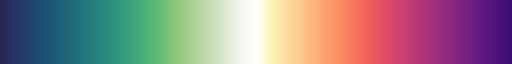

In [23]:
# Use truncated magma for scatter points 
colors = cm.get_cmap('magma')(np.linspace(0.1, 1, 256))
seq_cmap = matplotlib.colors.ListedColormap(colors, name='custom_cmap')

buffer = 0.01
raw_colors = np.concatenate((plt.get_cmap('cmr.seasons')(np.linspace(0.1, 0.5-buffer, 20)),
                            np.array([[1,1,1,1]]),
                            cm.get_cmap('magma_r')(np.linspace(buffer, 0.8, 20))))
f = scipy.interpolate.interp1d(np.linspace(0,1,len(raw_colors)), raw_colors.T)
colors = f(np.linspace(0,1,256)).T
div_cmap = matplotlib.colors.ListedColormap(colors, name='custom_cmap')
div_cmap.set_bad(color='red')
div_cmap

In [31]:
def plot_Fig_6(nino34_super, dmi_super, sam_super, had_nino34, had_dmi, jra_sam, 
               FFDI_super, DI_super, extreme_super, figsize=(6,6)):
    import matplotlib.path as mpath
    import matplotlib.patches as patches
    from mpl_toolkits.mplot3d import Axes3D
    from matplotlib.legend_handler import HandlerLine2D

    azim = 315
    elev = 35
    proj_type = 'ortho' #'persp'
    rect = (0.029, 0.028, 0.946, 0.946)

    # Markersizes
    ms = 30
    ms_obs = 6
    ms_border = 110
    ms_center = 30
    ms_dist = 47

    fig = plt.figure(figsize=figsize)

    # Define ellipse markers to look correct in each plane  =========================================
    def rotate_points(points, angle, center_point=(0, 0)):
        """Rotates a point around center_point(origin by default)
        Angle is in degrees.
        Rotation is counter-clockwise
        """
        from math import radians
        # Shift the point so that center_point becomes the origin
        new_points = points - np.array(center_point)
        c, s = np.cos(radians(angle % 360)), np.sin(radians(angle % 360))
        R = np.array(((c, -s), (s, c)))
        new_points = np.dot(new_points, R)
        return new_points + np.array(center_point)

    circle = mpath.Path.unit_circle()
    verts = np.copy(circle.vertices)
    verts[:, 0] *= 1.8
    xy_marker = mpath.Path(verts, circle.codes)
    shift_z = -2.5

    circle = mpath.Path.unit_circle()
    verts = np.copy(circle.vertices)
    verts[:, 0] *= 1.9
    verts = rotate_points(verts, -47)
    yz_marker = mpath.Path(verts, circle.codes)
    shift_x = -3.9

    circle = mpath.Path.unit_circle()
    verts = np.copy(circle.vertices)
    verts[:, 0] *= 1.9
    verts = rotate_points(verts, 47)
    xz_marker = mpath.Path(verts, circle.codes)
    shift_y = 3

    shrink_z = 11000/8000 # Factor to shrink markers on planes including z
    xlims = [shift_x, 4.3]
    ylims = [-6.6, shift_y]
    zlims = [shift_z, 4.9]

    # Add axis with grid lines ===========================================================
    # Axes3D actually plots the planes with the gridlines slightly back from the plotting plane
    # which presents badly for this plot. Manually correct for this here
    rect_reduced = (0.0292, 0.028, 0.946, 0.946)
    ax = Axes3D(fig, rect=rect_reduced,
                azim=azim, elev=elev, proj_type=proj_type)
    
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.set_xlabel(r'SOND NINO 3.4 / $\sigma_{\mathrm{NINO 3.4}}$', labelpad=-2)
    ax.set_ylabel(r'SOND SAM$_\mathrm{I}$ / $\sigma_{\mathrm{SAM_I}}$', labelpad=-2)
    ax.set_zlabel(r'SON DMI / $\sigma_{\mathrm{DMI}}$', labelpad=-2)
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    ax.set_zlim(zlims)

    ax.tick_params(axis='x', which='major', pad=-2)
    ax.tick_params(axis='y', which='major', pad=-2)
    ax.tick_params(axis='z', which='major', pad=-2)
    ax.grid(linewidth=0.5)
    
    # Add top axis lines ===========================================================
    # Note matplotlib struggles with layering in 3D so do this on a new axis
    ax = Axes3D(fig, rect=rect_reduced,
                azim=azim, elev=elev, proj_type=proj_type)
    
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')
    ax.grid(False)
    ax.patch.set_alpha(0)
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    ax.set_zlim(zlims)

    # Hack to add outer axis and ticks
#     tmp_planes = ax.zaxis._PLANES 
#     ax.zaxis._PLANES = ( tmp_planes[1], tmp_planes[0], 
#                          tmp_planes[3], tmp_planes[2], 
#                          tmp_planes[4], tmp_planes[5])
    tmp_planes = ax.zaxis._PLANES 
    ax.zaxis._PLANES = ( tmp_planes[1], tmp_planes[0], 
                         tmp_planes[3], tmp_planes[2], 
                         tmp_planes[4], tmp_planes[5])
    tmp_planes = ax.xaxis._PLANES 
    ax.xaxis._PLANES = ( tmp_planes[0], tmp_planes[4], 
                         tmp_planes[3], tmp_planes[2], 
                         tmp_planes[1], tmp_planes[5])
    tmp_planes = ax.yaxis._PLANES 
    ax.yaxis._PLANES = ( tmp_planes[1], tmp_planes[0], 
                         tmp_planes[3], tmp_planes[2], 
                         tmp_planes[5], tmp_planes[4])
    ax.set_xlabel(r'SOND NINO 3.4 / $\sigma_{\mathrm{NINO 3.4}}$', labelpad=-2)
    ax.set_ylabel(r'SOND SAM$_\mathrm{I}$ / $\sigma_{\mathrm{SAM_I}}$', labelpad=-2)
    ax.set_zlabel(r'SON DMI / $\sigma_{\mathrm{DMI}}$', labelpad=-2)
    ax.tick_params(axis='z', pad=0) # Spacing strangely large for zticks
    
    # Plot scatter plots of all model data ================================================
    # Plot all data on slightly large axis
    # Note matplotlib struggles with layering in 3D so do this on a new axis
    rect_full = (0, 0, 1, 1)
    ax = Axes3D(fig, rect=rect_full,
                azim=azim, elev=elev, proj_type=proj_type)

    fcst_nino34_std = nino34_super.std('sample')
    fcst_dmi_std = dmi_super.std('sample')
    fcst_sam_std = sam_super.std('sample')

    obsv_nino34_std = had_nino34.sel(time=slice('1980','2020')).std('time')
    obsv_dmi_std = had_dmi.sel(time=slice('1980','2020')).std('time')
    obsv_sam_std = jra_sam.sel(time=slice('1980','2020')).std('time')

    fcst_nino34_norm = nino34_super / fcst_nino34_std
    fcst_dmi_norm = dmi_super / fcst_dmi_std
    fcst_sam_norm = sam_super / fcst_sam_std
    obsv_nino34_norm = had_nino34 / obsv_nino34_std
    obsv_dmi_norm = had_dmi / obsv_dmi_std
    obsv_sam_norm = jra_sam / obsv_sam_std

    ax.scatter(fcst_nino34_norm, fcst_sam_norm, zs=shift_z, zdir='z', 
               s=ms, lw=0.5, marker=xy_marker,
               facecolor=[0.75,0.75,0.75], edgecolor=[0.45,0.45,0.45], alpha=1)
    ax.scatter(fcst_sam_norm, fcst_dmi_norm, zs=shift_x, zdir='x', 
               s=ms/shrink_z, lw=0.5, marker=yz_marker,
               facecolor=[0.75,0.75,0.75], edgecolor=[0.45,0.45,0.45], alpha=1)
    ax.scatter(fcst_nino34_norm, fcst_dmi_norm, zs=shift_y, zdir='y', 
               s=ms/shrink_z, lw=0.5, marker=xz_marker,
               facecolor=[0.75,0.75,0.75], edgecolor=[0.45,0.45,0.45], alpha=1)

    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.set_xlabel(r'SOND NINO 3.4 / $\sigma_{\mathrm{NINO 3.4}}$', labelpad=-2)
    ax.set_ylabel(r'SOND SAM$_\mathrm{I}$ / $\sigma_{\mathrm{SAM_I}}$', labelpad=-2)
    ax.set_zlabel(r'SON DMI / $\sigma_{\mathrm{DMI}}$', labelpad=-2)
    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')
    ax.grid(False)
    ax.patch.set_alpha(0)
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    ax.set_zlim(zlims)
    ax.axis('off')

    # Plot kernel density estimates of pdfs ================================
    # Note matplotlib struggles with layering in 3D so do this on a new axis
    ax = Axes3D(fig, rect=rect_full,
                azim=azim, elev=elev, proj_type=proj_type, clip_on=True)

    def kde(x, y, npoints=60):
            """ 2D kernel density estimate """
            from scipy import stats
            x_I, y_I = np.mgrid[2*x.min().values:2*x.max().values:complex(npoints), 
                                2*y.min().values:2*y.max().values:complex(npoints)]
            x = x[~np.isnan(x)]
            y = y[~np.isnan(y)]
            positions = np.vstack([x_I.ravel(), y_I.ravel()])
            values = np.vstack([x, y])
            kernel = stats.gaussian_kde(values)
            KDE = np.reshape(kernel(positions).T, x_I.shape)
            return x_I, y_I, KDE

    levels = [2e-2, 5e-2, 1e-1, 2e-1]
    X_kde, Y_kde, Z_kde = kde(fcst_nino34_norm, fcst_sam_norm)
    ax.contour(X_kde, Y_kde, Z_kde, zdir='z', offset=shift_z, 
               levels=levels, linestyles='--', linewidths=0.75, colors='k')
    X_kde, Y_kde, Z_kde = kde(fcst_sam_norm, fcst_dmi_norm)
    ax.contour(Z_kde, X_kde, Y_kde, zdir='x', offset=shift_x, 
               levels=levels, linestyles='--', linewidths=0.75, colors='k')
    X_kde, Y_kde, Z_kde = kde(fcst_nino34_norm, fcst_dmi_norm)
    ax.contour(X_kde, Z_kde, Y_kde, zdir='y', offset=shift_y, 
               levels=levels, linestyles='--', linewidths=0.75, colors='k')

    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')
    ax.patch.set_alpha(0)
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    ax.set_zlim(zlims)
    ax.axis('off')

    # Plot model data during unprecented events ============================
    # Note matplotlib struggles with layering in 3D so do this on a new axis
    ax = Axes3D(fig, rect=rect_full,
                azim=azim, elev=elev, proj_type=proj_type, clip_on=True)  

    def _dist(FFDI, DI):
        FFDI_dist = (FFDI - FFDI.mean('sample')) / FFDI.std('sample')
        DI_dist = (DI - DI.mean('sample')) / DI.std('sample')
        return np.sqrt(FFDI_dist**2 + DI_dist**2)

    p1 = ax.scatter(fcst_nino34_norm.where(extreme_super, drop=True), 
                    fcst_sam_norm.where(extreme_super, drop=True), 
                    zs=shift_z,  zdir='z', 
                    c=_dist(FFDI_super.where(extreme_super, drop=True), 
                            DI_super.where(extreme_super, drop=True)),
                    s=ms_dist, lw=0.75, marker=xy_marker,
                    cmap=seq_cmap, edgecolor='k', alpha=1, vmin=0, vmax=3.3)
    p1 = ax.scatter(fcst_sam_norm.where(extreme_super, drop=True), 
                    fcst_dmi_norm.where(extreme_super, drop=True), 
                    zs=shift_x,  zdir='x', 
                    c=_dist(FFDI_super.where(extreme_super, drop=True), 
                            DI_super.where(extreme_super, drop=True)),
                    s=ms_dist/shrink_z, lw=0.75, marker=yz_marker,
                    cmap=seq_cmap, edgecolor='k', alpha=1, vmin=0, vmax=3.3)
    p1 = ax.scatter(fcst_nino34_norm.where(extreme_super, drop=True), 
                    fcst_dmi_norm.where(extreme_super, drop=True), zs=shift_y,  zdir='y', 
                    c=_dist(FFDI_super.where(extreme_super, drop=True), 
                            DI_super.where(extreme_super, drop=True)),
                    s=ms_dist/shrink_z, lw=0.75, marker=xz_marker,
                    cmap=seq_cmap, edgecolor='k', alpha=1, vmin=0, vmax=3.3)

    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')
    ax.patch.set_alpha(0)
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    ax.set_zlim(zlims)
    ax.axis('off')

    # Plot observation data ================================================
    # Note matplotlib struggles with layering in 3D so do this on a new axis
    ax = Axes3D(fig, rect=rect_full,
                azim=azim, elev=elev, proj_type=proj_type, clip_on=True) 

    obsv_nino34_period = obsv_nino34_norm.sel(time=obsv_period)
    obsv_dmi_period = obsv_dmi_norm.sel(time=obsv_period)
    obsv_sam_period = obsv_sam_norm.sel(time=obsv_period)

    ax.scatter(obsv_nino34_period, obsv_sam_period, zs=shift_z, zdir='z',
               s=ms, lw=0.75, marker=xy_marker, 
               facecolor='w', edgecolor='k', alpha=1)
    ax.text(obsv_nino34_period.sel(time='2019-12').item()-0.25, 
            obsv_sam_period.sel(time='2019-12').item()-0.05, shift_z, "2019",
            fontsize=plt.rcParams['font.size']-1)

    ax.scatter(obsv_sam_period, obsv_dmi_period, zs=shift_x, zdir='x',
               s=ms/shrink_z, lw=0.75, marker=yz_marker, 
               facecolor='w', edgecolor='k', alpha=1)
    ax.text(shift_x-0.45, obsv_sam_period.sel(time='2019-12').item(), 
            obsv_dmi_period.sel(time='2019-12').item()-0.10, "2019", 
            fontsize=plt.rcParams['font.size']-1)

    ax.scatter(obsv_nino34_period, obsv_dmi_period, zs=shift_y, zdir='y',
               s=ms/shrink_z, lw=0.75, marker=xz_marker, 
               facecolor='w', edgecolor='k', alpha=1)
    ax.text(obsv_nino34_period.sel(time='2019-12').item()-0.2, shift_y, 
            obsv_dmi_period.sel(time='2019-12').item()-0.5, "2019", 
            fontsize=plt.rcParams['font.size']-1)

    # Quadrant lines ----- 
    ax.plot3D([xlims[0], xlims[1]], [0,0], 
              zs=shift_z, zdir='z', color='k', linewidth=0.75)
    ax.plot3D([0,0], [ylims[0], ylims[1]], 
              zs=shift_z, zdir='z', color='k', linewidth=0.75)
    ax.plot3D([xlims[0], xlims[1]], [0,0], 
              zs=shift_y, zdir='y', color='k', linewidth=0.75)
    ax.plot3D([0,0], [zlims[0], zlims[1]], 
              zs=shift_y, zdir='y', color='k', linewidth=0.75)
    ax.plot3D([ylims[0], ylims[1]], [0,0], 
              zs=shift_x, zdir='x', color='k', linewidth=0.75)
    ax.plot3D([0,0], [zlims[0], zlims[1]], 
              zs=shift_x, zdir='x', color='k', linewidth=0.75)

    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')
    ax.patch.set_alpha(0)
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    ax.set_zlim(zlims)
    ax.axis('off')

    # Legend ==============================================================   
    class HandlerXoffset(HandlerLine2D):
        def __init__(self, marker_pad=0.3, numpoints=1, x_offset=0,  **kw):
            HandlerLine2D.__init__(self, marker_pad=marker_pad, numpoints=numpoints, **kw)
            self._xoffset = x_offset
        def get_xdata(self, legend, xdescent, ydescent, width, height, fontsize):
            numpoints = self.get_numpoints(legend)
            if numpoints > 1:
                xdata = np.linspace(-xdescent + self._marker_pad * fontsize,
                                    width - self._marker_pad * fontsize,
                                    numpoints) - self._xoffset
                xdata_marker = xdata
            elif numpoints == 1:
                xdata = np.linspace(-xdescent, width, 2) - self._xoffset
                xdata_marker = [0.5 * width - 0.5 * xdescent - self._xoffset]
            return xdata, xdata_marker

    sm, = ax.plot(np.nan, np.nan, linewidth=0, marker='o', markersize=5, 
                  markerfacecolor=[0.7,0.7,0.7], markeredgecolor=[0.45,0.45,0.45], markeredgewidth=0.75)
    lm, = ax.plot(np.nan, np.nan, linestyle='--', linewidth=0.75, color='k')
    so, = ax.plot(np.nan, np.nan, linewidth=0, marker='o', markersize=5, 
                  markerfacecolor='w', markeredgecolor='k', markeredgewidth=0.75)
    sm1, = ax.plot(np.nan, np.nan, linewidth=0, marker='o', markersize=6, 
                   markerfacecolor=cm.get_cmap(seq_cmap)(0.3), markeredgecolor='k', markeredgewidth=0.75)
    l = ax.legend(
        [(lm, sm), (sm1), so],
        [f'    Model: {fcst_period.start[:4]}-{fcst_period.stop[:4]}',
         r'    Model: unpr. $\overline{\mathrm{FFDI}}_{\mathrm{Dec}}$ and $\overline{\mathrm{DI}}$', 
         f'    Observations: {obsv_period.start[:4]}-{obsv_period.stop[:4]}'],\
        handler_map={sm1:HandlerXoffset(x_offset=-5),
                     lm:HandlerXoffset(x_offset=-2), 
                     sm:HandlerXoffset(x_offset=-10),
                     so:HandlerXoffset(x_offset=-5)}, framealpha=0.75, loc='upper left', 
        bbox_to_anchor=[0.083,0.055, 0, 0.97])
    for text in l.get_texts():
        text.set_color("k")


    # Colorbars =========================================================
    cax1 = fig.add_axes([0.53, 1.0, 0.48, 0.018])
    slide = 26
    c1 = plt.colorbar(
        p1, cax=cax1, orientation='horizontal', 
        label=' '*slide+'Normalised distance from\n'+' '*(slide+7)+
        r'mean $\overline{\mathrm{FFDI}}_{\mathrm{Dec}}$ and $\overline{\mathrm{DI}}$')
    cax1.xaxis.set_ticks_position('bottom')
    cax1.xaxis.set_label_position('bottom')
    cax1.tick_params(axis='x', which='major', pad=0)

    ax.text(-4.7, -6.5, 5, r'$\bf{a}$',
            horizontalalignment='left',
            verticalalignment='top')

    # Quandrants =========================================================
    # No better way to do this than to place these manually...
    text_col = 'k'

    def _def_text(index_1, index_2, extreme_super):
        index_1_ext = index_1.where(extreme_super, drop=True)
        index_2_ext = index_2.where(extreme_super, drop=True)
        gl = (index_1_ext >= 0) & (index_2_ext <= 0)
        ll = (index_1_ext <= 0) & (index_2_ext <= 0)
        lg = (index_1_ext <= 0) & (index_2_ext >= 0)
        gg = (index_1_ext >= 0) & (index_2_ext >= 0)
        return 100 * gl.mean().values, 100 * ll.mean().values, 100 * lg.mean().values, 100 * gg.mean().values 

    # x-y plane
    gl, ll, lg, gg = _def_text(fcst_nino34_norm, fcst_sam_norm, extreme_super)
    ax.text(3.6, -5.5, shift_z, f'{gl:.0f}%',
            horizontalalignment='right', verticalalignment='top', zdir='x', color=text_col)
    ax.text(-3.5, -5.6, shift_z, f'{ll:.0f}%',
            horizontalalignment='right', verticalalignment='top', zdir='x', color=text_col)
    ax.text(-3.4, 3.2, shift_z, f'{lg:.0f}%',
            horizontalalignment='right', verticalalignment='top', zdir='x', color=text_col)
    ax.text(3.7, 3.2, shift_z, f'{gg:.0f}%',
            horizontalalignment='right', verticalalignment='top', zdir='x', color=text_col)

    # x-z plane
    gl, ll, lg, gg = _def_text(fcst_nino34_norm, fcst_dmi_norm, extreme_super)
    ax.text(4.1, shift_y, -1.5, f'{gl:.0f}%',
            horizontalalignment='right', verticalalignment='top', zdir='x', color=text_col)
    ax.text(-3.1, shift_y, 4.9, f'{lg:.0f}%',
            horizontalalignment='right', verticalalignment='top', zdir='x', color=text_col)
    ax.text(4.1, shift_y, 5.0, f'{gg:.0f}%',
            horizontalalignment='right', verticalalignment='top', zdir='x', color=text_col)

    # y-z plane
    gl, ll, lg, gg = _def_text(fcst_sam_norm, fcst_dmi_norm, extreme_super)
    ax.text(shift_x, -5.2, -2.0, f'{ll:.0f}%', 
            horizontalalignment='right', verticalalignment='top', zdir='y', color=text_col)
    ax.text(shift_x, -5.2, 4.45, f'{lg:.0f}%',
            horizontalalignment='right', verticalalignment='top', zdir='y', color=text_col)
    ax.text(shift_x, 3.0, 4.5, f'{gg:.0f}%',
            horizontalalignment='right', verticalalignment='top', zdir='y', color=text_col)
    
    # Print the proportion of all points in the "fire-conducive quadrant"
    nino34_ext = fcst_nino34_norm.where(extreme_super, drop=True)
    dmi_ext = fcst_dmi_norm.where(extreme_super, drop=True)
    sam_ext = fcst_sam_norm.where(extreme_super, drop=True)
    p = 100 * ((nino34_ext >= 0) & (dmi_ext >= 0) & (sam_ext <= 0)).mean().values
    print(f'Proportion in +ve ENSO, +ve DMI, -ve SAM: {p:.0f}%')

    # SST composite ======================================================
    ax = fig.add_axes([0.081, -0.26, 0.41, 0.3], projection=ccrs.PlateCarree(180))

    p = f6_sst_composite.plot.contourf(
        cmap=div_cmap, ax=ax, transform=ccrs.PlateCarree(),
        cbar_kwargs={'pad': 0.17, 'aspect': 25, 'orientation': 'horizontal',
                     'label': 'SON sea surface temperature anomaly', 
                     'ticks': np.round(10*np.arange(-2.4, 2.7, 0.6))/10},
        vmin=-2.6, vmax=2.6, levels=20) 
    for c in p.collections:
        c.set_edgecolor("face")

    ax.add_feature(cartopy.feature.LAND, color=[0.94,0.94,0.94])
    p.axes.coastlines(color=[0.3,0.3,0.3], linewidth=0.5)
    ax.set_xticks(np.arange(-180,180,60), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(-90,100,30), crs=ccrs.PlateCarree())
    ax.tick_params(axis="both",direction='in')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    gl_labels = ax.gridlines(crs=ccrs.PlateCarree(),
                             draw_labels=True,
                             linewidth=0, 
                             color='grey', 
                             linestyle='-',
                             xlocs=np.arange(-180,180,60),
                             ylocs=np.arange(-90,100,30))
    gl_labels.xlabels_top = False
    gl_labels.ylabels_right=False
    gl_labels.xlabel_style = {'fontsize': fontsize, 
                              'color': rc_context['text.color']}
    gl_labels.ylabel_style = {'fontsize': fontsize, 
                              'color': rc_context['text.color']}
    ax.set_title('')
    ax.set_xlabel('')
    ax.set_ylabel('')

    ax.text(-0.06, 1.04, r'$\bf{b}$',
            horizontalalignment='left',
            verticalalignment='top',
            transform = ax.transAxes)

    rectW = patches.Rectangle((50, -10), 20, 20, transform=ccrs.PlateCarree(), 
                             linewidth=0.75, edgecolor='k', linestyle='--', facecolor='none')
    ax.add_patch(rectW)
    rectE = patches.Rectangle((90, -10), 20, 10, transform=ccrs.PlateCarree(), 
                             linewidth=0.75, edgecolor='k', linestyle='--', facecolor='none')
    ax.add_patch(rectE)
    rect = patches.Rectangle((190, -5), 50, 10, transform=ccrs.PlateCarree(), 
                             linewidth=0.75, edgecolor='k', linestyle='--', facecolor='none')
    ax.add_patch(rect)

    # h500 composite ======================================================
    ax = fig.add_axes([0.54, -0.26, 0.41, 0.3], projection=ccrs.PlateCarree(180))

    p = f6_h500_composite.plot.contourf(
        cmap=div_cmap, ax=ax, transform=ccrs.PlateCarree(),
        cbar_kwargs={'pad': 0.17, 'aspect': 25, 'orientation': 'horizontal',
                     'label': 'SOND 500 hPa geopotential height anomaly', 
                     'ticks': range(-100, 110, 25)},
        vmin=-110, vmax=110, levels=20)
    for c in p.collections:
        c.set_edgecolor("face")

    p.axes.coastlines(color='w', linewidth=1)
    p.axes.coastlines(color=[0.3,0.3,0.3], linewidth=0.5)
    ax.set_xticks(np.arange(-180,180,60), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(-90,100,30), crs=ccrs.PlateCarree())
    ax.yaxis.tick_right()
    ax.tick_params(axis="both",direction='in')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    gl_labels = ax.gridlines(crs=ccrs.PlateCarree(),
                             draw_labels=True,
                             linewidth=0, 
                             color='grey', 
                             linestyle='-',
                             xlocs=np.arange(-180,180,60),
                             ylocs=np.arange(-90,100,30))
    gl_labels.xlabels_top = False
    gl_labels.ylabels_left=False
    gl_labels.ylabels_right=True
    gl_labels.xlabel_style = {'fontsize': fontsize, 
                              'color': rc_context['text.color']}
    gl_labels.ylabel_style = {'fontsize': fontsize, 
                              'color': rc_context['text.color']}

    ax.set_title('')
    ax.set_xlabel('')
    ax.set_ylabel('')

    ax.text(-0.05, 1.03, r'$\bf{c}$',
            horizontalalignment='left',
            verticalalignment='top',
            transform = ax.transAxes)

    ax.plot([-180, 180], [-40, -40], #transform=ccrs.PlateCarree(), 
            color='k', linewidth=0.75, linestyle='--')
    ax.plot([-180, 180], [-65, -65], #transform=ccrs.PlateCarree(), 
            color='k', linewidth=0.75, linestyle='--')

    # There is a bug with cartopy right labels with projection=ccrs.PlateCarree(!=0) so hack these
    pos = ax.get_position()
    ax = fig.add_axes(pos, projection=ccrs.PlateCarree(0))
    gl_labels = ax.gridlines(crs=ccrs.PlateCarree(),
                             draw_labels=True,
                             linewidth=0, 
                             color='grey', 
                             linestyle='-',
                             xlocs=np.arange(-180,180,60),
                             ylocs=np.arange(-90,100,30))
    gl_labels.top_labels = False
    gl_labels.left_labels = False
    gl_labels.bottom_labels = False
    gl_labels.ylabel_style = {'fontsize': fontsize, 
                              'color': rc_context['text.color']}
    ax.set_facecolor('none')
    ax.outline_patch.set_visible(False)
    
    return fig

Proportion in +ve ENSO, +ve DMI, -ve SAM: 79%


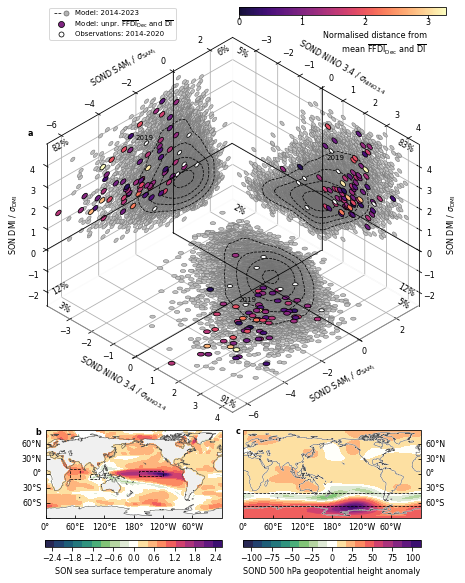

In [32]:
ax_color = 'k'
fontsize = 8
rc_context = {'axes.edgecolor':ax_color, 
              'xtick.color':ax_color, 
              'ytick.color':ax_color,
              'axes.labelcolor': ax_color,
              'text.color': ax_color,
              'font.size': fontsize,
              'legend.fontsize' : fontsize-1,
              'legend.columnspacing': 0.7,
              'legend.labelspacing' : 0.2,
              'legend.handlelength' : 1.1}

with plt.rc_context(rc_context):
    fig = plot_Fig_6(
        nino34_super, dmi_super, sam_super, 
        had_nino34, had_dmi, jra_sam, 
        FFDI_super, DI_super, extreme_super, figsize=(6,6))
    
fig.savefig(f'./figures/conditioning.pdf', format='pdf',
            bbox_inches='tight')

--------
# Condition likelihoods of exceedance on positive values of Nino 3.4, DMI and SAM

### Spin up a LocalCluster for the bootstrapping

In [26]:
cluster.close()
client.close()

from dask.distributed import LocalCluster, Client

cluster = LocalCluster()
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Status: running,Using processes: True
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 48,Total memory: 188.57 GiB
Comm: tcp://127.0.0.1:40653,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 48
Started: Just now,Total memory: 188.57 GiB
Comm: tcp://127.0.0.1:37743,Total threads: 6
Dashboard: http://127.0.0.1:42927/status,Memory: 23.57 GiB
Nanny: tcp://127.0.0.1:44057,


In [27]:
def conditional_likelihood(condition, alpha=5, n_bootstraps=10_000):
    """ Calculate likelihood conditioned on a boolean 
        Returns sample value and confidence bounds from bootstrapping 
    """
    def _likelihood(FFDI, DI):
        return 100 * ((FFDI >= FFDI_event) & (DI <= DI_event)).mean()
    FFDI_cond = FFDI_super.where(condition, drop=True)
    DI_cond = DI_super.where(condition, drop=True)
    likelihood_samp =  _likelihood(FFDI_cond, DI_cond).item()
    likelihood_bs = my.n_random_resamples(xr.merge((FFDI_cond, DI_cond)),
                                          samples={'sample': (len(FFDI_cond['sample']), 1)},
                                          function=lambda x:
                                          _likelihood(x['FFDI_DEC'], x['precip_ann']),
                                          n_repeats=n_bootstraps)
    likelihood_conf_lower = likelihood_bs.quantile(q=alpha/200, dim='k').item()
    likelihood_conf_upper = likelihood_bs.quantile(q=1-alpha/200, dim='k').item()
    return likelihood_samp, likelihood_conf_lower, likelihood_conf_upper

In [33]:
%%time
conditional_likelihoods = {
    'any': (
        conditional_likelihood(xr.full_like(FFDI_super, True))),
    'DMI': (
        conditional_likelihood(dmi_super > 0), 
        conditional_likelihood(dmi_super > dmi_super.std())),
    'NINO 3.4': (
        conditional_likelihood(nino34_super > 0), 
        conditional_likelihood(nino34_super > nino34_super.std())),
    '-SAM$_{\mathrm{I}}$': (
        conditional_likelihood(-sam_super > 0), 
        conditional_likelihood(-sam_super > sam_super.std())),
    'NINO 3.4 & DMI': (
        conditional_likelihood((nino34_super > 0) & (dmi_super > 0)), 
        conditional_likelihood((nino34_super > nino34_super.std()) & (dmi_super > dmi_super.std()))),
    'DMI & -SAM$_{\mathrm{I}}$': (
        conditional_likelihood((dmi_super > 0) & (-sam_super > 0)), 
        conditional_likelihood((dmi_super > dmi_super.std()) & (-sam_super > sam_super.std()))),
    'NINO 3.4 & -SAM$_{\mathrm{I}}$': (
        conditional_likelihood((nino34_super > 0) & (-sam_super > 0)), 
        conditional_likelihood((nino34_super > nino34_super.std()) & (-sam_super > sam_super.std()))),
    'NINO 3.4 & DMI & -SAM$_{\mathrm{I}}$': (
        conditional_likelihood((nino34_super > 0) & (dmi_super > 0) & (-sam_super > 0)), 
        conditional_likelihood((nino34_super > nino34_super.std()) & (dmi_super > dmi_super.std()) & (-sam_super > sam_super.std())))}

CPU times: user 7min 41s, sys: 26.1 s, total: 8min 7s
Wall time: 10min 7s


### Occurrences in historical record

In [34]:
sam_occ = jra_sam
nino34_occ = had_nino34.sel(time=sam_occ.time)
dmi_occ = had_dmi.sel(time=sam_occ.time)

historical_occurences = {
    'DMI': (
        dmi_occ > 0, 
        dmi_occ > dmi_occ.std()),
    'NINO 3.4': (
        nino34_occ > 0, 
        nino34_occ > nino34_occ.std()),
    '-SAM$_{\mathrm{I}}$': (
        -sam_occ > 0, 
        -sam_occ > sam_occ.std()),
    'NINO 3.4 & DMI': (
        (nino34_occ > 0) & (dmi_occ > 0), 
        (nino34_occ > nino34_occ.std()) & (dmi_occ > dmi_occ.std())),
    'DMI & -SAM$_{\mathrm{I}}$': (
        (dmi_occ > 0) & (-sam_occ > 0), 
        (dmi_occ > dmi_occ.std()) & (-sam_occ > sam_occ.std())),
    'NINO 3.4 & -SAM$_{\mathrm{I}}$': (
        (nino34_occ > 0) & (-sam_occ > 0), 
        (nino34_occ > nino34_occ.std()) & (-sam_occ > sam_occ.std())),
    'NINO 3.4 & DMI & -SAM$_{\mathrm{I}}$': (
        (nino34_occ > 0) & (dmi_occ > 0) & (-sam_occ > 0), 
        (nino34_occ > nino34_occ.std()) & (dmi_occ > dmi_occ.std()) & (-sam_occ > sam_occ.std()))}

## Plot Fig 7 for paper

In [35]:
def plot_Fig_7(conditional_likelihoods, historical_occurences, figsize=(3.12, 2.56)):
    fig = plt.figure(constrained_layout=True, figsize=figsize)

    errorbar_capsize = 3
    errorbar_lw = 0.75

    ax = fig.add_subplot(111)
    ax.grid(linewidth=0.5, zorder=-1)

    labels = []

    # Do first key ("any") case separately
    conditional_likelihoods = conditional_likelihoods.copy()
    first = conditional_likelihoods.pop('any')
    samp = first[0]
    conf = np.vstack((first[0]-first[1], first[2]-first[0]))
    ax.bar(0, samp, facecolor=[0.7,0.7,0.7], edgecolor='k', lw=0.75, zorder=2)
    ax.errorbar(0, samp, conf, 
                ecolor='k', lw=errorbar_lw, zorder=3, 
                capsize=errorbar_capsize)
    labels.append('any')

    for idx, ((cond_key, cond_value), (occ_key, occ_value)) in enumerate(
        zip(conditional_likelihoods.items(), historical_occurences.items())):
        assert cond_key == occ_key
        key = cond_key

        samp = cond_value[1][0]
        conf = np.vstack((samp-cond_value[1][1], cond_value[1][2]-samp))
        occ = occ_value[1]
        ax.bar(idx+1, samp, facecolor=cm.get_cmap('magma')(0.6), 
               alpha=0.6, edgecolor='k', lw=0.75, zorder=2, 
               label='> 1 std' if idx==0 else '__nolabel__')
        ax.errorbar(idx+1, samp, conf, 
                    ecolor=cm.get_cmap('magma')(0.6), lw=errorbar_lw, zorder=3, 
                    capsize=errorbar_capsize)
        ax.text(idx+0.63, samp-0.30, f'{occ.sum().item():1.0f}', 
                ha='left', fontsize=rc_context['font.size']-1)
        if 2019 in occ.where(occ, drop=True).time.dt.year:
            ax.text(idx+0.63, samp-0.40, 
                    r'$\overline{'+'\,\,\,\,'*len(f'{occ.sum().item():1.0f}')+'}$', 
                    ha='left', fontsize=rc_context['font.size']-1)

        samp = cond_value[0][0]
        conf = np.vstack((samp-cond_value[0][1], cond_value[0][2]-samp))
        occ = occ_value[0]
        ax.bar(idx+1, samp, facecolor=cm.get_cmap('magma')(0.3), 
               alpha=0.5, edgecolor='k', lw=0.75, zorder=2, 
               label='> 0' if idx==0 else '__nolabel__')
        ax.errorbar(idx+1, samp, conf, 
                    ecolor=cm.get_cmap('magma')(0.3), lw=errorbar_lw, zorder=3, 
                    capsize=errorbar_capsize)
        ax.text(idx+0.63, 0.12, f'{occ.sum().item():1.0f}', 
                ha='left', fontsize=rc_context['font.size']-1, color='w')
        if 2019 in occ.where(occ, drop=True).time.dt.year:
            ax.text(idx+0.63, 0.02, 
                    r'$\overline{'+'\,\,\,\,'*len(f'{occ.sum().item():1.0f}')+'}$', 
                    ha='left', fontsize=rc_context['font.size']-1, color='w')

        labels.append(key)

    ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7])
    ax.set_xticklabels(labels, rotation=26, ha="right", rotation_mode="anchor")
    ax.set_yticks(np.arange(0, 6, 1))
    ax.set_ylabel('Likelihood [%]')
    
    ax.legend()
    
    return fig

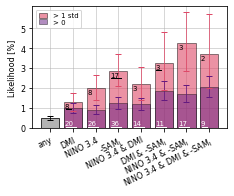

In [36]:
ax_color = 'k'
fontsize = 8
rc_context = {'axes.edgecolor':ax_color, 
              'xtick.color':ax_color, 
              'ytick.color':ax_color,
              'axes.labelcolor': ax_color,
              'text.color': ax_color,
              'font.size': fontsize,
              'legend.fontsize' : fontsize-1,
              'legend.columnspacing': 0.7,
              'legend.labelspacing' : 0.05,
              'legend.handlelength' : 1.2}

with plt.rc_context(rc_context):
    fig = plot_Fig_7(conditional_likelihoods, historical_occurences, 
                     figsize=(3.12, 2.56))
    
fig.savefig(f'./figures/conditional_likelihoods.pdf', format='pdf',
            bbox_inches='tight')

--------
# End notebook

In [278]:
cluster.close()
client.close()